# Анализ данных по коронавирусу часть 2, попытка сравнить с тем, что было в Китае. 

Ввиду того, что коронавирус всё же распространился по всему миру, я решил сопоставить данные по вирусу в сравнение с тем, что было в Китае. Когда пандемия только начиналась, я сделал небольшой [анализ данных по Китаю](https://habr.com/ru/post/489100/), и так как там ситуация почти локализована, то интересно было бы посмотреть в какой стадии находятся другие страны, где пандемия начала сильно распространяться. Данный анализ ни на что не претендует и является субъективным мнением автора.

![](virus_photo.jpg)
© [Роспотребнадзор](https://www.rospotrebnadzor.ru/)

## 1. Получение данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(20, 5)})

В первом [анализе данных](https://habr.com/ru/post/489100/) я использовал данные напрямую из отчетов [ВОЗ](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports), но в этот раз удобнее было взять их из отчётов университета Джонса Хопкинса, которые находятся [здесь](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series).

In [2]:
confirmed = pd.read_csv('time_series_19-covid-Confirmed.csv')
recovered = pd.read_csv('time_series_19-covid-Recovered.csv')
deaths = pd.read_csv('time_series_19-covid-Deaths.csv')

In [3]:
# страны с самым большим количесвом заразившихся людей
df = confirmed.copy()
df = df.groupby('Country/Region').sum()
df = df.sort_values(by=df.columns[-1], ascending=False)

countries = list(df.head(5).index)

Из этих данных я получил страны в которых наибольшее число заразившихся людей и выбрал из них пять стран с наихудшей ситуацией включая Китай.

In [15]:
print(countries)

['China', 'Italy', 'Iran', 'Spain', 'Germany']


In [5]:
def transform_data(df, countries):
    df = df[df['Country/Region'].isin(countries)]
    columns = [i for i in df.columns if i not in ['Province/State', 'Lat', 'Long']]
    df = df[columns]    
    df = df.groupby('Country/Region').sum()
    
    df = df.T
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
    df = df.reset_index(drop=True)
    df.columns.name = None
    
    def by_day(col):
        res = col.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
        res[0] = col[0]
        return res
    
    df[countries] = df[countries].apply(by_day)
    
    return df

Затем для каждой из пяти стран я расчитал количество заразившихся, умерших и выздоравивших за день.

In [6]:
confirmed = transform_data(confirmed, countries)
recovered = transform_data(recovered, countries)
deaths = transform_data(deaths, countries)

## 2. Чистка данных от выбросов

К сожалению данные о количестве выздоровивших совсем не подходят для анализа, т.к. сильно разобобщены и совсем не имеют никакой динамики, по-этому я их не буду использовать.

Чистка выбросов для количества заразившихся людей заключается в том, что когда два дня подряд сильно выбиваются из общей картины, т.е. в одинь день подозрительно мало, в другой слишком много заразившихся, то я просто беру их среднее число. Однако по Китаю за числа 2020-02-12 - 2020-02-14 данные уж слишком сильно выбиваются из общей картины, по-этому за эти даты я взял данные из своего [первого отчета](https://habr.com/ru/post/489100/), который я сделал на основе данных отчетов [ВОЗ](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports).

In [7]:
confirmed.loc[confirmed['Date'].isin(['2020-02-22', '2020-02-23']), 'China'] = confirmed.loc[confirmed['Date'].isin(['2020-02-22', '2020-02-23']), 'China'].mean()

#2020-02-12 - 2020-02-14 Данные из отчётов ВОЗ
confirmed.loc[confirmed['Date'] == '2020-02-12', 'China'] = 2022
confirmed.loc[confirmed['Date'] == '2020-02-13', 'China'] = 1820
confirmed.loc[confirmed['Date'] == '2020-02-14', 'China'] = 1998

confirmed.loc[confirmed['Date'].isin(['2020-03-12', '2020-03-13']), 'Italy'] = confirmed.loc[confirmed['Date'].isin(['2020-03-12', '2020-03-13']), 'Italy'].mean()

confirmed.loc[confirmed['Date'].isin(['2020-03-12', '2020-03-13']), 'Spain'] = confirmed.loc[confirmed['Date'].isin(['2020-03-12', '2020-03-13']), 'Spain'].mean()

В данных по количеству умерших я почистил данные аналгоично, т.е. если в данных были два подряд идущие дня выбивающиеся из общей динамики, то я брал их среднее.

In [8]:
deaths.loc[deaths['Date'].isin(['2020-01-28', '2020-01-29']), 'China'] = deaths.loc[deaths['Date'].isin(['2020-01-28', '2020-01-29']), 'China'].mean()
deaths.loc[deaths['Date'].isin(['2020-02-12', '2020-02-13']), 'China'] = deaths.loc[deaths['Date'].isin(['2020-02-12', '2020-02-13']), 'China'].mean()
deaths.loc[deaths['Date'].isin(['2020-02-21', '2020-02-22']), 'China'] = deaths.loc[deaths['Date'].isin(['2020-02-21', '2020-02-22']), 'China'].mean()
deaths.loc[deaths['Date'].isin(['2020-02-23', '2020-02-24']), 'China'] = deaths.loc[deaths['Date'].isin(['2020-02-23', '2020-02-24']), 'China'].mean()

deaths.loc[deaths['Date'].isin(['2020-03-12', '2020-03-13']), 'Italy'] = deaths.loc[deaths['Date'].isin(['2020-03-12', '2020-03-13']), 'Italy'].mean()

## 3. Отрисовка граффиков

In [9]:
def draw_graph(deaths, confirmed, country):
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha="right")
    sns.lineplot(x='Date', y=country, data=deaths, ax=ax, color='b', label='Умершие', marker='o')
    ax.set(xlabel='Дата', ylabel='Кол-во умерших за день')
    plt.legend(bbox_to_anchor=(0.01, 0.95), loc='upper left')
    ax2 = ax.twinx()
    sns.lineplot(x='Date', y=country, data=confirmed, ax=ax2, color='r', label='Инфицированные', marker='o')
    ax2.set(ylabel='Кол-во инфицированных за день');
    plt.legend(bbox_to_anchor=(0.01, 0.85), loc='upper left');

    ax.set(xticks=confirmed['Date'].values);

Как и в [первом отчете](https://habr.com/ru/post/489100/), я наложил графики количества заразившихся и количества умерших за день друг на друга.

### Китай:

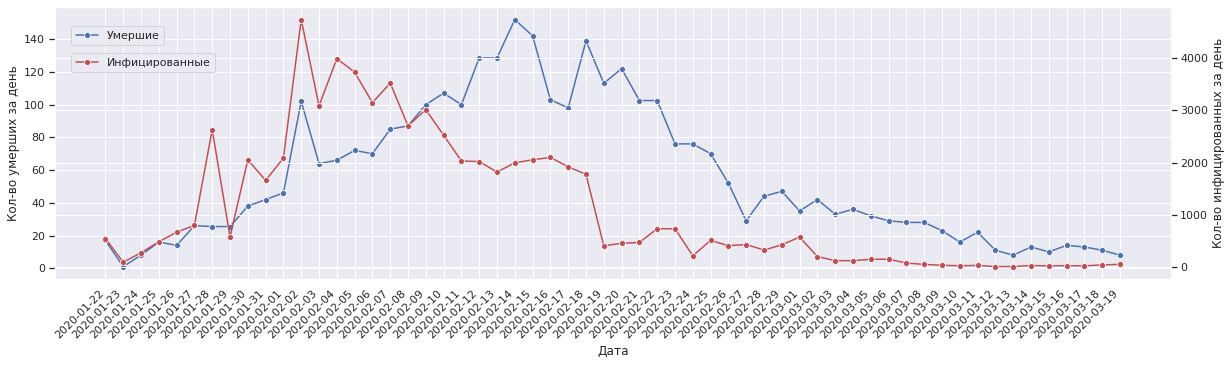

In [10]:
draw_graph(deaths, confirmed, 'China')

На граффике по Китаю видно смещение пиков, которое объясняется инкубационным периодом вируса (что было верно подмечено [здесь](https://habr.com/ru/post/489100/#comment_21299882) пользователем @Andy_U в комментариях по [первому анализу](https://habr.com/ru/post/489100/)), именно с таким развитием событий я и пытаюсь сравнить данные по другим странам.

### Италия:

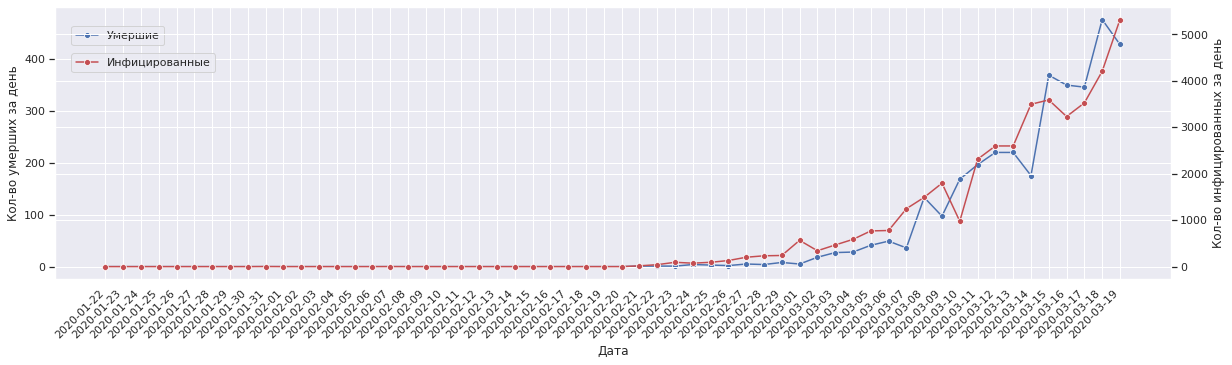

In [11]:
draw_graph(deaths, confirmed, 'Italy')

### Иран:

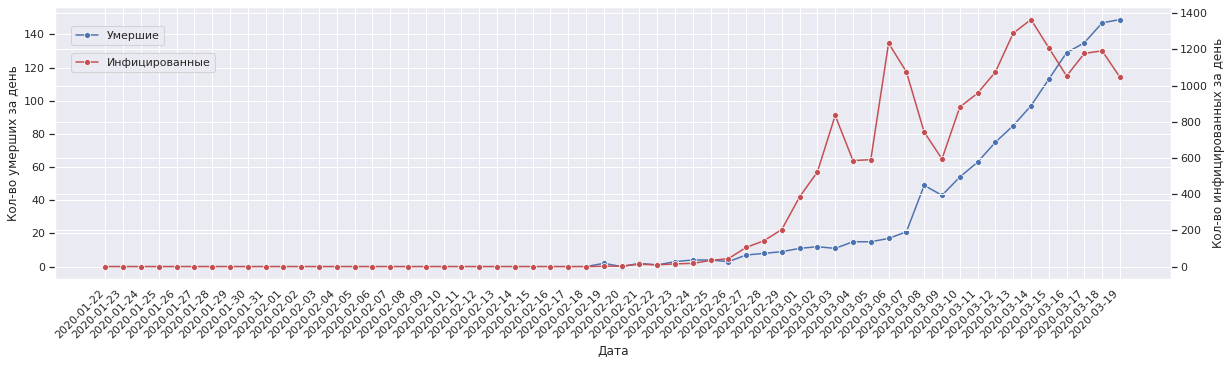

In [12]:
draw_graph(deaths, confirmed, 'Iran')

Возможно в Иране намечается разворот?, по крайней мере на это похоже.

### Испания:

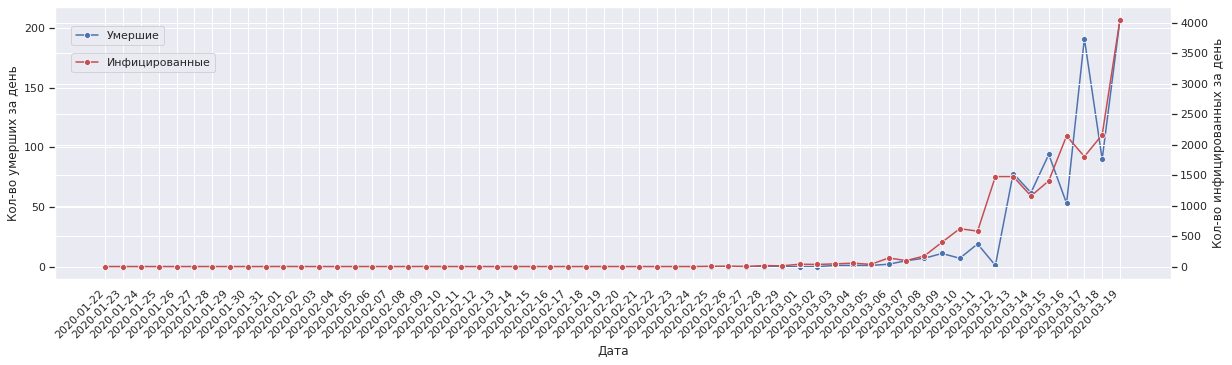

In [13]:
draw_graph(deaths, confirmed, 'Spain')

### Германия:

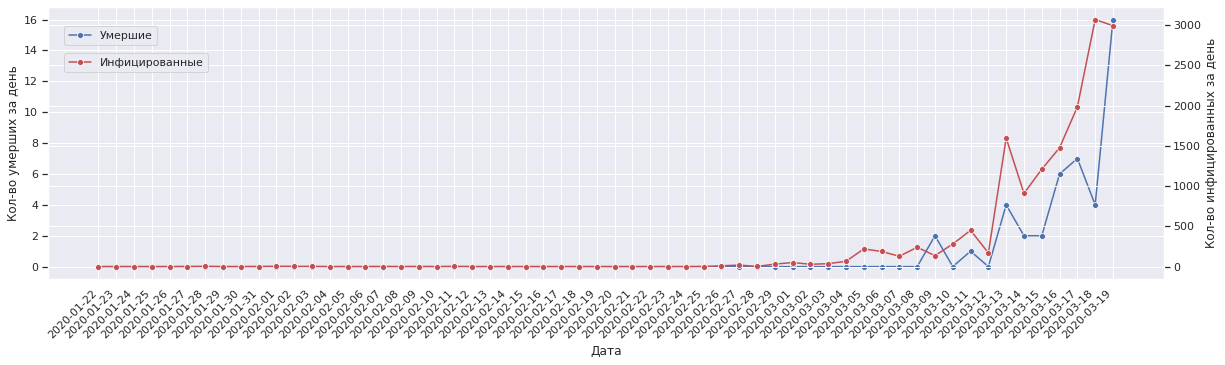

In [14]:
draw_graph(deaths, confirmed, 'Germany')

## 4. Выводы

Из граффиков видно, что пандемия только набирает обороты, хотя возможно, намечается разворот в данных по Ирану. Повторю опять, что я пытаюсь сравнить граффики того, что было в Китае с тем, что сейчас происходит в других странах и похоже прогноз пока негативный.